In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.constants import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA]
NUM_CLASSES = len(CLASSES) - 1

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [5]:
# PGD Parameters
kwargs = {
        'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60, 
        'targeted': True,
        'should_normalize': True
}

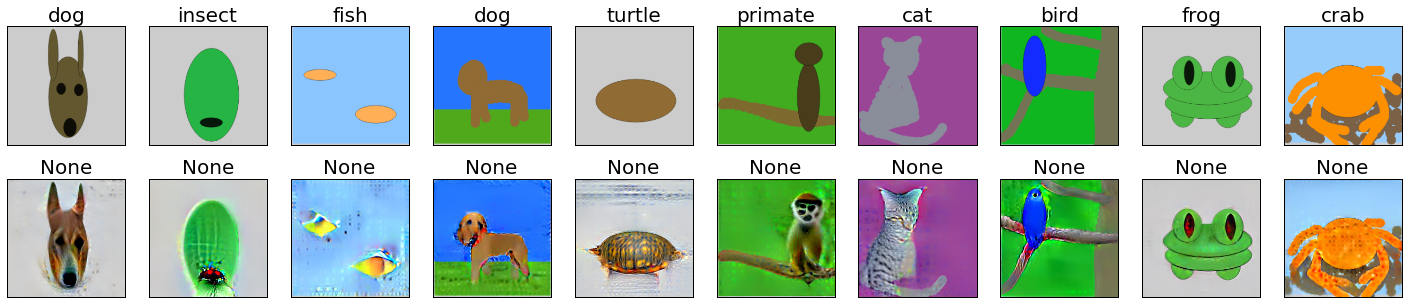

In [6]:
# Load images
sketch = ch.cat([ch.load(f'./sample_inputs/demo_s_{i}.pt') for i in range(10)])
targ = ch.tensor([0, 8, 6, 0, 3, 5, 1, 4, 2, 7]).long()

_, img = model(sketch, targ, make_adv=True, **kwargs)
show_image_row([sketch.cpu(), img.detach().cpu()], 
               tlist=[[CLASSES[int(t)] for t in targ], [None] * 10],
               fontsize=20)